# Software development patterns through git data mining

In [1]:
import sys, os, getpass, warnings
warnings.filterwarnings('ignore')
from patterns.visualizer import Visualizer

Create a `Visualizer` object for a project, e.g., for Spack, `vis = Visualizer('spack')`. This brings in data from database and annotate it with *locc*, *locc+*, *locc-*, *change-size-cos* = *1-similarity* (**expensive call**). The data is cached locally after it's fetched from the database and subsequently loaded from disk, unless you specify the `cache=False` parameter, e.g., `vis.get_data(cache=False)`. Available projects include `'lammps', 'spack', 'petsc', 'Nek5000', 'nwchem', 'E3SM', 'qmcpack', 'qdpxx', 'LATTE', 'namd', 'enzo-dev'` (the full list can be obtained with by calling the `Visualizer()` constructor without arguments.

The `get_data` method automatically removes changes associated with non-code files. The determination of what is code is made by including common suffixes, as well as checking manually a sampling of ECP projects for the suffixes used for things that can be labeled as code (vs. input simulation data, documentation, or generated files), for a list of suffixes, refer to the `Patterns.code_suffixes` list in [patterns.py](https://github.com/HPCL/ideas-uo/blob/master/src/patterns/patterns.py). This makes the analysis of decades of project data feasible. You can disable this if desired, by passing the `code_only=False` parameter to `get_data`. You can also explicitly remove non-code rows with `vis.remove_noncode()`. Optionally, you can remove files that are likely copies of external code (path contains `extern` or `contrib`) with `vis.remove_external()`.

In [2]:
vis = Visualizer(project_name='nwchem')
vis.get_data()

INFO: Loaded local cached copy of nwchem data.
INFO: Cleaning up data and computing averages...
INFO: Done computing averages. 96148 file changes (code only)


In [3]:
removed = vis.remove_external()

INFO: No external files found. Total size: 96148 changes


               locc+          locc-  change-size-cos
count     109.000000     109.000000       109.000000
mean    66068.009174   23362.477064       402.128440
std    155192.851241   94698.197964       700.496386
min       464.000000       7.000000         4.000000
max    846134.000000  647971.000000      4697.000000


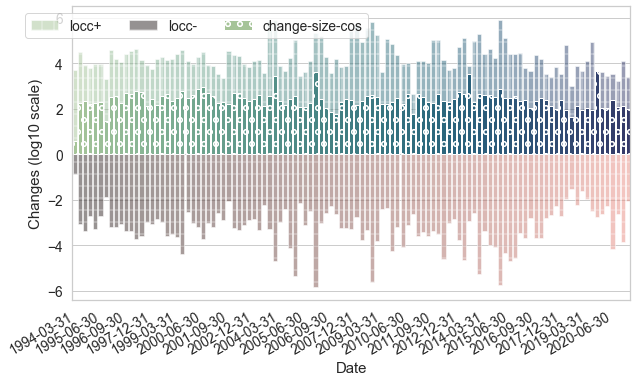

In [4]:
df = vis.plot_overall_project_locc(log=True)

to focus on a given year and/or month, set *year* and *month* fields

In [5]:
vis.set_year(2020)
vis.set_month(10)

to plot for a given year, provide *time_range='year'*

              locc+         locc-  change-size-cos
count     12.000000     12.000000        12.000000
mean    1769.833333   1838.333333        50.500000
std     2846.898051   4169.073962        43.787711
min       24.000000      6.000000         9.000000
max    10399.000000  13672.000000       176.000000


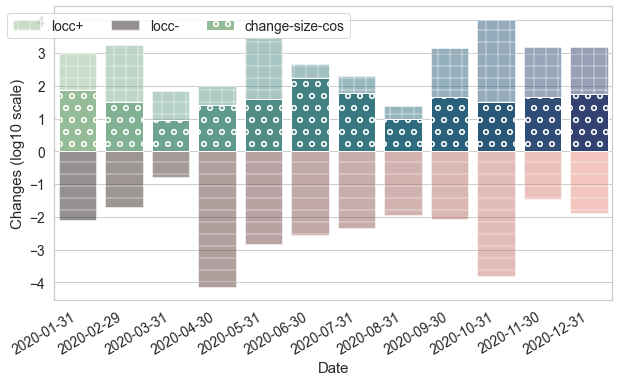

In [6]:
df = vis.plot_overall_project_locc(time_range='year',log=True)

similarly to plot for a given month, set *time_range='month'*

             locc+        locc-  change-size-cos
count    28.000000    28.000000        28.000000
mean    371.392857   237.321429         1.178571
std    1459.233927  1254.807409         3.139398
min       0.000000     0.000000         0.000000
max    7436.000000  6640.000000        14.000000


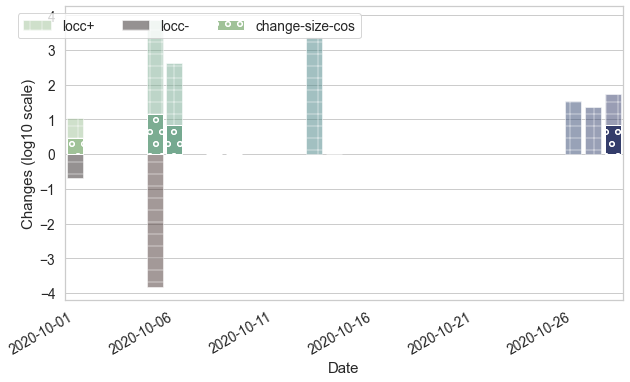

In [7]:
df = vis.plot_overall_project_locc(time_range='month',log=True)

### Finding trends with averages
We can plot the annual averages timeline for the entire project's history (by default showing LOCC and cos distance) with `plot_total_avg`. Several moving average plots are available, with different aggregation granularities (year, month) and different sliding window sizes.

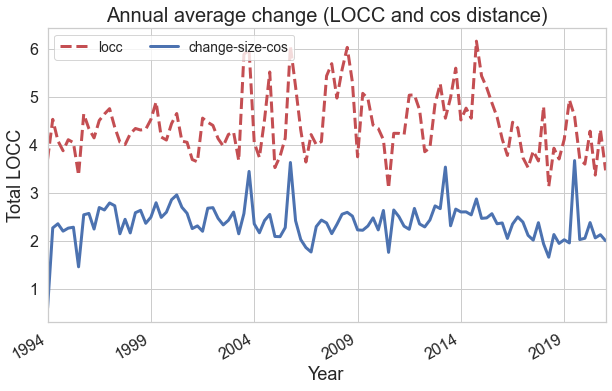

In [8]:
vis.plot_total_avg(log=True)

We can also compute different moving averages, indicating the aggregation frequency with the `freq` paramater. The default is `quarter`.

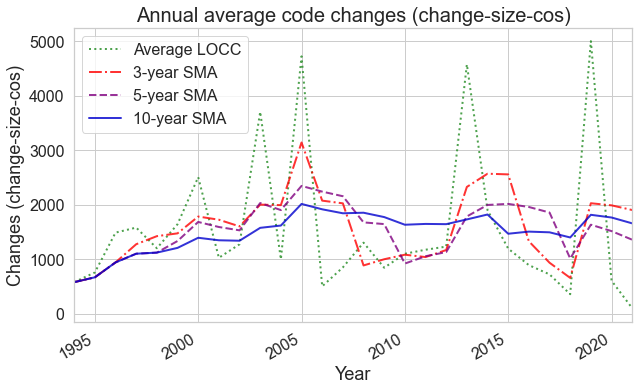

In [9]:
vis.plot_total_moving_avgs(freq='year')

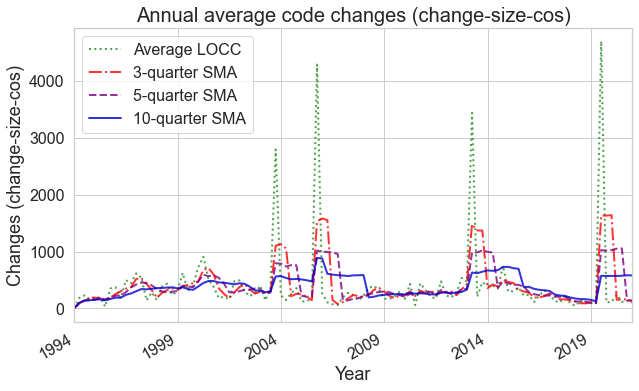

In [10]:
vis.plot_total_moving_avgs()

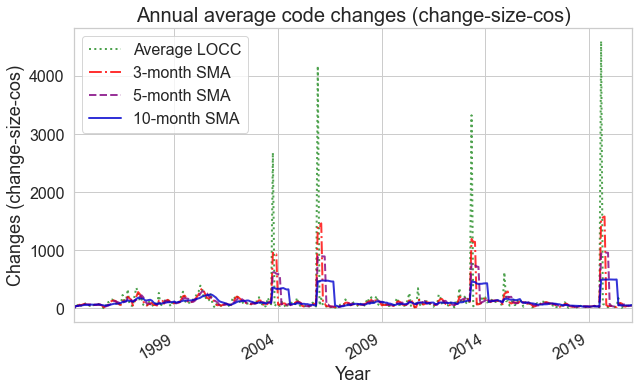

In [11]:
vis.plot_total_moving_avgs(freq='month')

## More timelines
This reflects changed lines of code as reported in git commit diffs. We have two functions that generate timeline plots of a change metric: `plot_proj_change_line` and `plot_proj_change_bubble`. By default, they show the entire range of selected dates and use the cos distance metric. You can specify a different metric with the `locc_metric` argument, e.g., `vis.plot_proj_change_line(locc_metric='locc')`

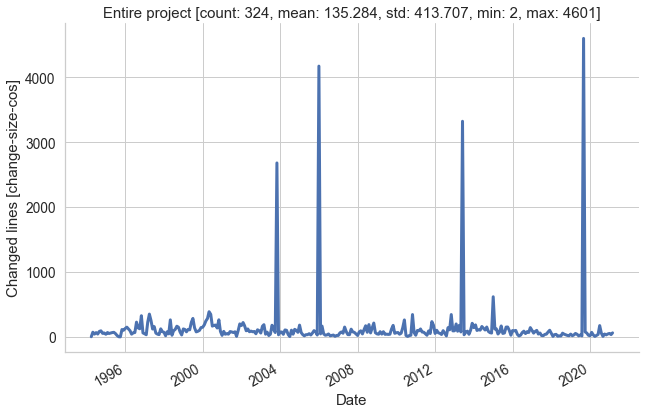

In [12]:
df = vis.plot_proj_change_line()

And looking at both line counts (LOCC) and the distance based `change-size-cos` at the same time. If not specified, the time_range argument defaults None, which indicates the entire time period of the dataset.

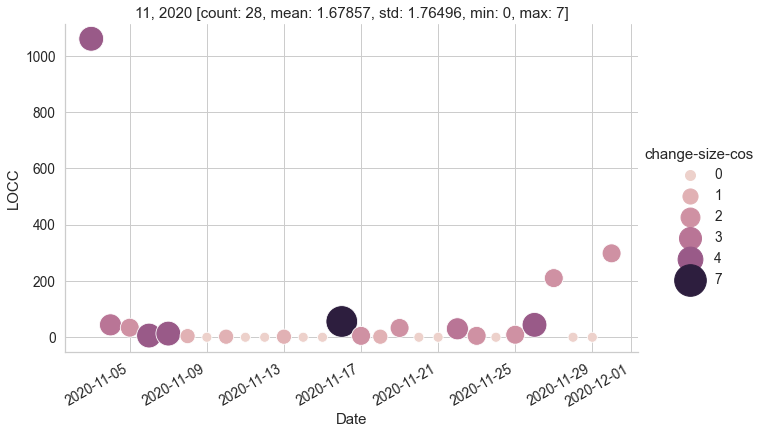

In [13]:
vis.set_month(11)
df = vis.plot_proj_change_bubble(time_range="month")

We can choose to zoom into a specific year, recall that previously we did `vis.set_year(2020)`.

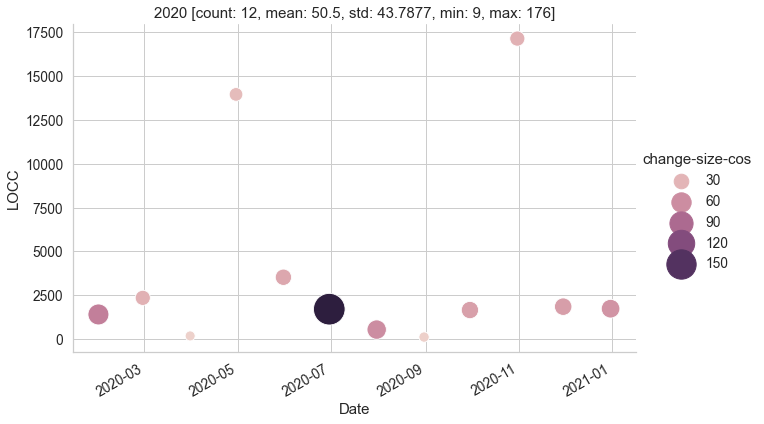

In [14]:
df = vis.plot_proj_change_bubble(time_range='year')

Or a specific year range.

               locc+          locc-  change-size-cos
count     109.000000     109.000000       109.000000
mean    66068.009174   23362.477064       402.128440
std    155192.851241   94698.197964       700.496386
min       464.000000       7.000000         4.000000
max    846134.000000  647971.000000      4697.000000


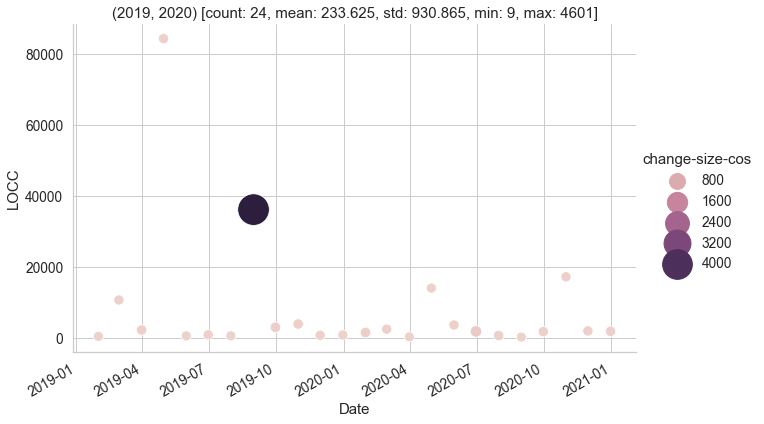

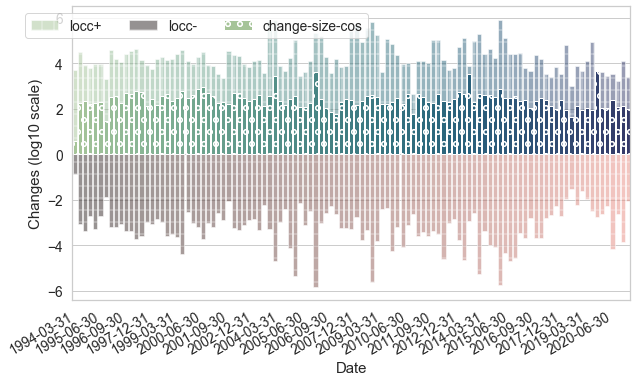

In [15]:
vis.select_year_range(2019,2020)
vis.plot_proj_change_bubble(time_range='year-year')
df = vis.plot_overall_project_locc(time_range='year-year',log=True)

We can also zoom into a single month; recall we previously did:
```
vis.set_year(2019)
vis.set_month(10)
```

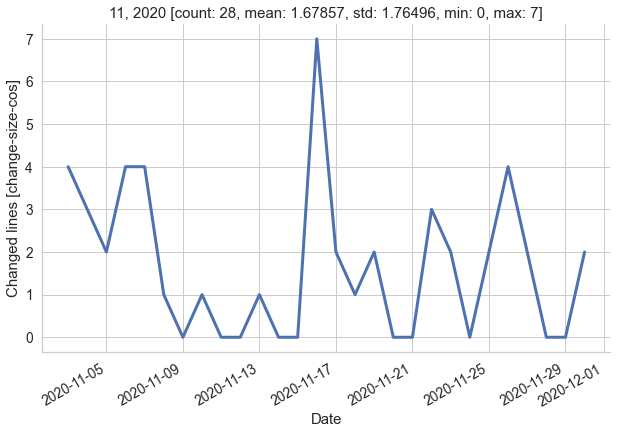

In [16]:
_ = vis.plot_proj_change_line(time_range='month')

Or a month range

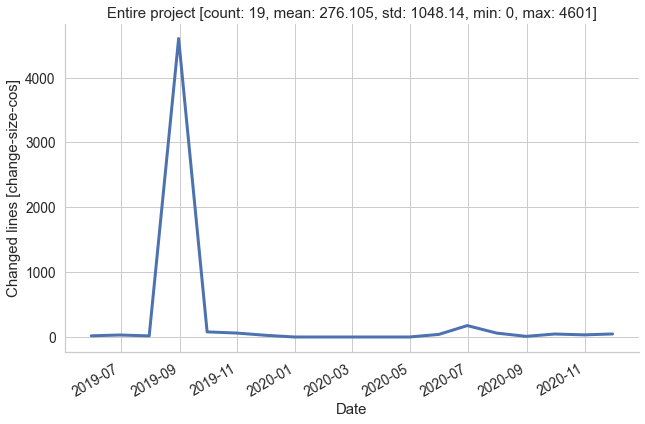

In [17]:
vis.select_month_range(5,11)
df = vis.plot_proj_change_line(time_range='month-month')

## Using a text distance metric to adjust the size of the changes

We use the python [textdistance](https://github.com/life4/textdistance) module. The following algorithms have been integrated with the visualizer.
```
'cos', 'hamming', 'damerau_levenshtein', 'jaccard', 'jaro', 'jaro_winkler', 'bag', 'editex'
```
Any of the above plots can be made with any line counting metric, typically specified through the `locc_metric` argument.

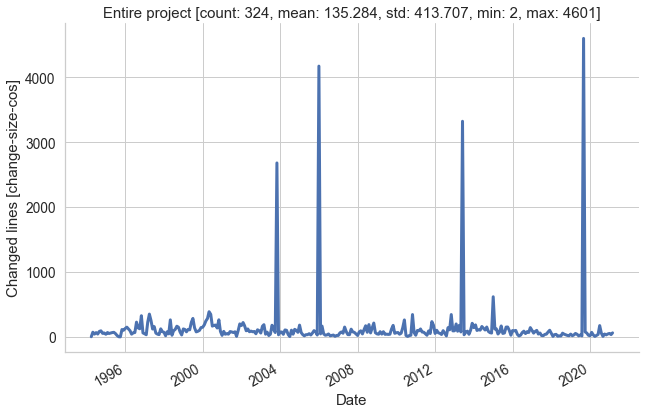

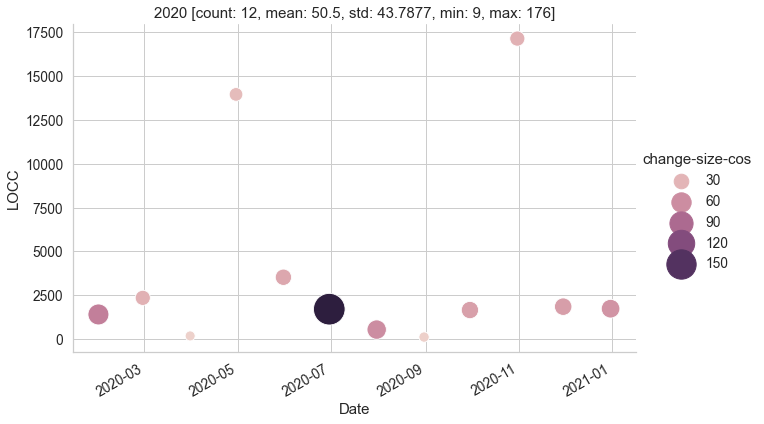

In [18]:
vis.set_diff_alg('jaccard')
df = vis.plot_proj_change_line()
_ = vis.plot_proj_change_bubble()

## More patterns
Here we look at a combination of the the high-churn and domain champion patterns. Basically we are focusing on the files that have the most changes and restricting the developers by those with the biggest contributions. One tricky issue that makes this nontrivial is that contributors use different names for their contributions. We have implemented a fuzzy name matching scheme of author names using the python `fuzzywuzzy` package to consolidate single-author contributions as much as possible.

INFO: Creating developer matrix...


unique_author,"Hammond, Jeff R",Huub Van Dam,So Hirata,Karol Kowalski,Edoardo Aprà
filepath,,,,,
src/nwxc/maxima/f77/nwxcm_c_m06.F,0,1198030,0,0,0
src/nwxc/maxima/f77/nwxcm_c_tpss03.F,0,103268,0,0,0
src/tce/ccsdt_alpha_new/ccsdt_lr_alpha2.F,226183,0,0,0,0
src/tce/ccsdt_beta/ccsdt_lr_beta_2.F,224928,0,0,0,0
src/tce/ccsdt_beta/ccsdt_lr_beta_4.F,186517,0,0,0,0


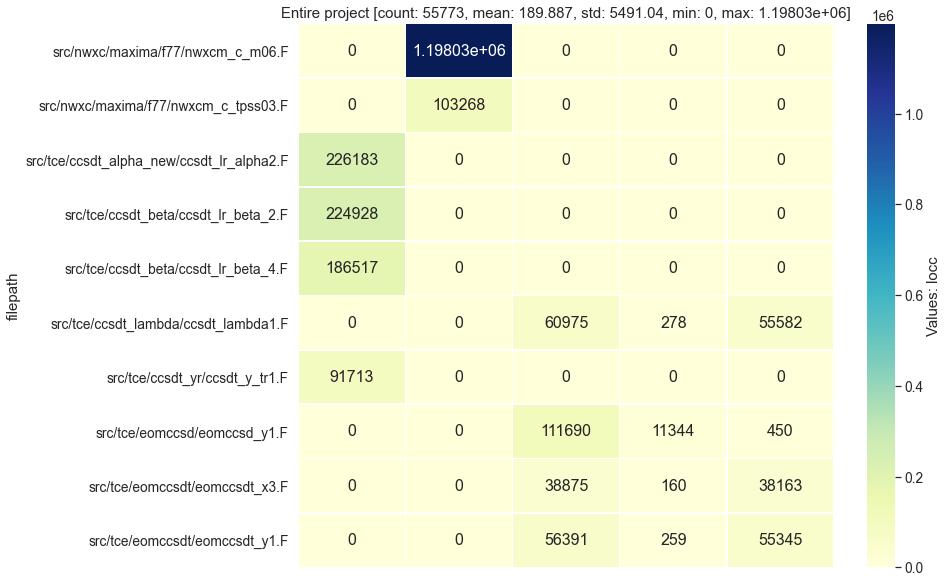

In [19]:
N = 10
vis.reset()
#vis.set_unique_authors()  # force author recomputation, this is expensive, so the result will be cached
vis.set_max_label_length(30)
top_N = vis.plot_top_N_heatmap(N, locc_metric='locc')
top_N.head()

INFO: Creating developer matrix...


unique_author,Edoardo Aprà,edoapra,Karol Kowalski,Eric Bylaska,Tjerk Straatsma,Huub Van Dam,Robert Harrison,So Hirata,Marat Valiev,Niri Govind
filepath,,,,,,,,,,
src/cafe/cf_main.F,1,0,0,0,144,1,0,0,0,0
src/config/makefile.h,253,64,0,9,12,6,22,0,0,2
src/driver/opt_drv.F,8,3,0,12,0,3,37,0,12,1
src/geom/geom.F,9,2,0,12,0,11,43,0,6,1
src/geom/geom_input.F,36,1,0,12,2,10,45,0,12,2


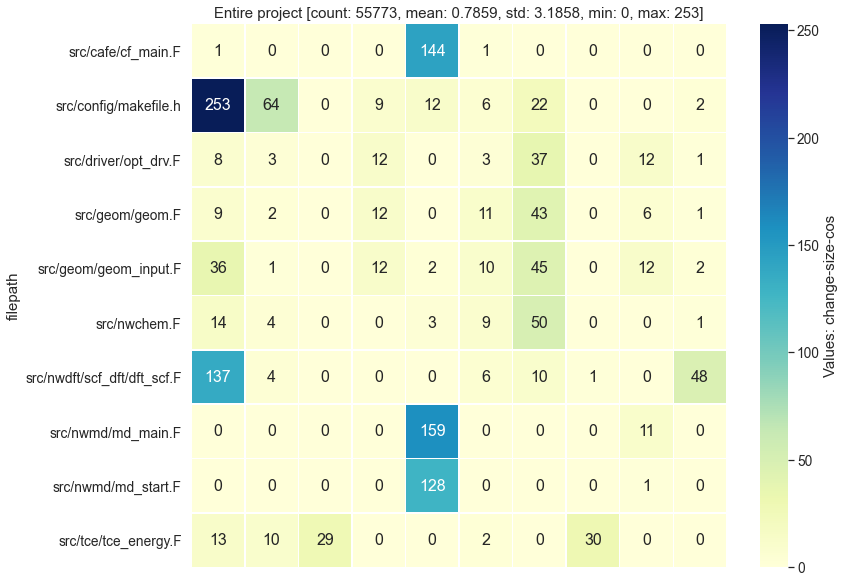

In [20]:
top_N_cos = vis.plot_top_N_heatmap(N, locc_metric='change-size-cos')
top_N_cos.head()

INFO: Creating developer matrix...


unique_author,Eric Bylaska,edoapra,"Hammond, Jeff R",Edoardo Aprà,naromero77,Michael Klemm
filepath,,,,,,
.github/workflows/github_actions.yml,0,0,0,16,0,0
.gitlab-ci.yml,0,6,0,0,0,0
contrib/mkdocs/mkdocs.yml,0,10,0,0,0,0
src/config/makefile.h,0,17,1,2,0,4
src/nwpw/band/cpsd/band_sd.F,8,0,0,0,0,0


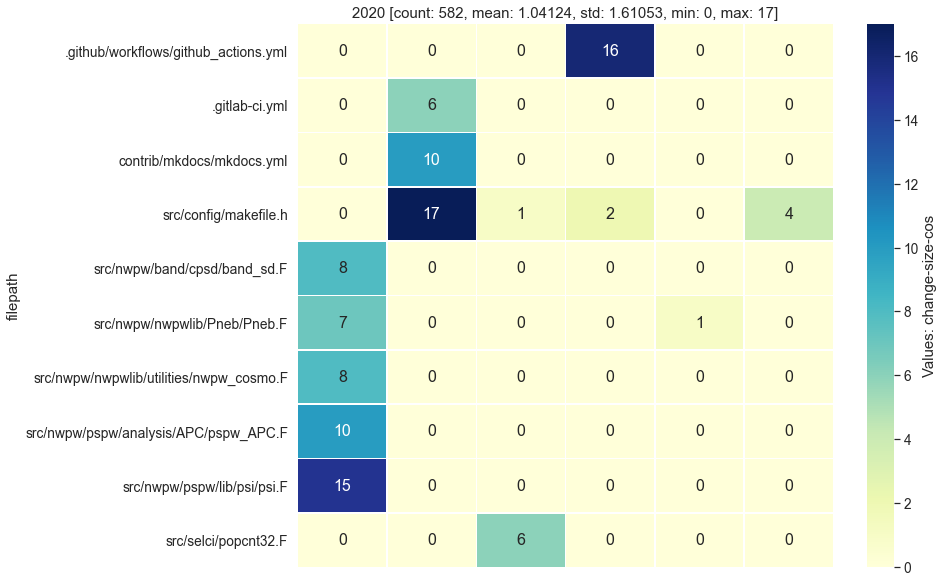

In [21]:
vis.set_year(2020)
top_N_cos = vis.plot_top_N_heatmap(N, time_range='year', locc_metric='change-size-cos')
top_N_cos.head()

We can also easily see the exact differences between different ways of measuring change. This is not something that we normally compute frequently, hence there isn't a special plot function.

In [22]:
file_dev_locc, _ = vis.make_file_developer_df(locc_metric='locc')
file_dev_diff, _ = vis.make_file_developer_df(locc_metric='change-size-cos')

INFO: Creating developer matrix...
INFO: Creating developer matrix...


Total number of developers: 96
INFO: Creating developer matrix...


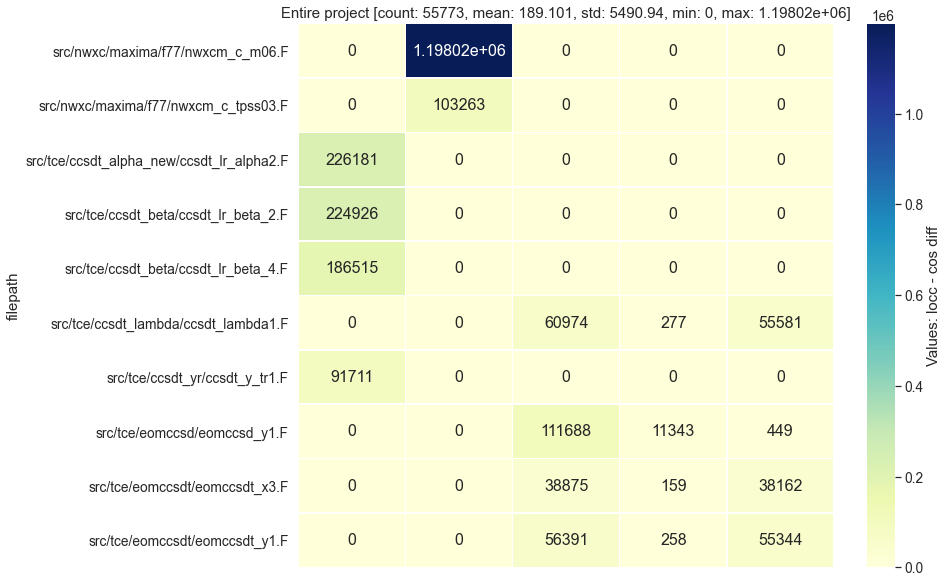

In [23]:
diff_df = file_dev_locc.sub(file_dev_diff, axis=0)
print("Total number of developers: %d" % diff_df.shape[1])
df = vis.commit_data
df['locc - cos diff'] = df['locc']-df['change-size-cos']
d = vis.plot_top_N_heatmap(top_N = 10, locc_metric='locc - cos diff', my_df=df)

We can generate the "hot-files" data for any time period, the way we select it is the same as previously described.

INFO: Creating developer matrix...


unique_author,edoapra,Eric Bylaska,Daniel Mejia Rodriguez
filepath,,,
.gitlab-ci.yml,59,0,0
src/ddscf/movecs_molden.F,50,0,0
src/ddscf/vectors_inp.F,14,0,0
src/nwdft/scf_dft/dft_nwmolden.F,28,0,0
src/nwdft/scf_dft/dft_scf.F,8,0,0


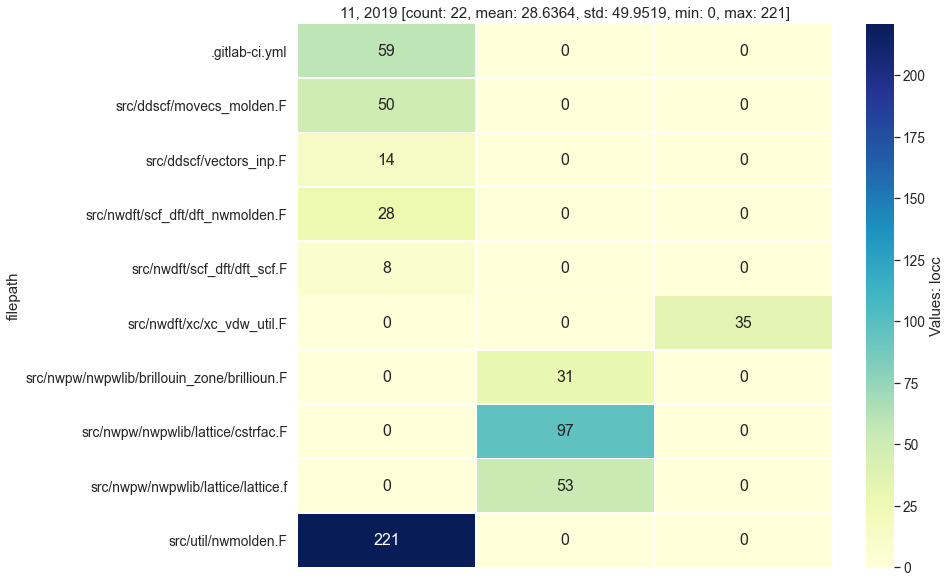

In [24]:
N = 10
vis.set_year(2019)
vis.set_month(11)
vis.set_max_label_length(30)
top_N = vis.plot_top_N_heatmap(N, time_range="month",locc_metric='locc')
top_N.head()

## In the zone
Here we look at what days of the week and times of day developers are most productive. This one also takes the usual argumemts, the defaults are `time_range=None, locc_metric='change-size-cos'`

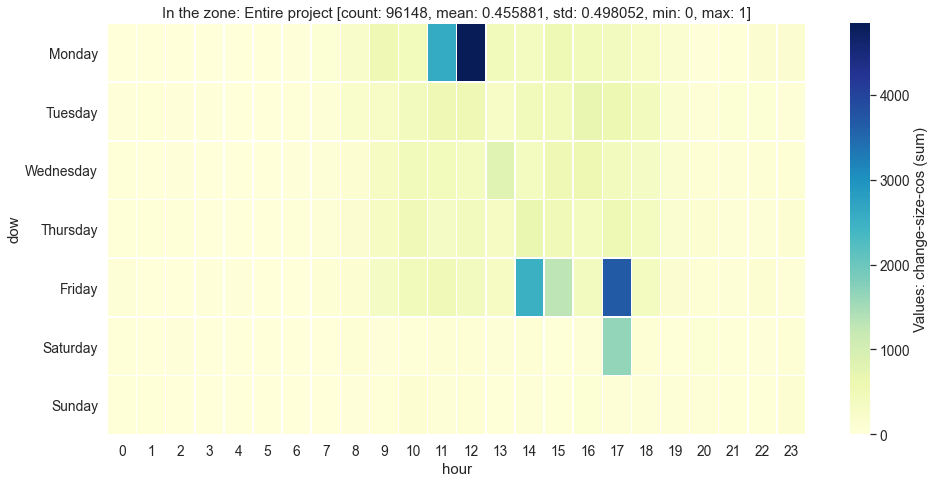

In [25]:
df = vis.plot_zone_heatmap(agg='sum')

We can also zoom down to month level, here we show year by year heatmaps of activity.

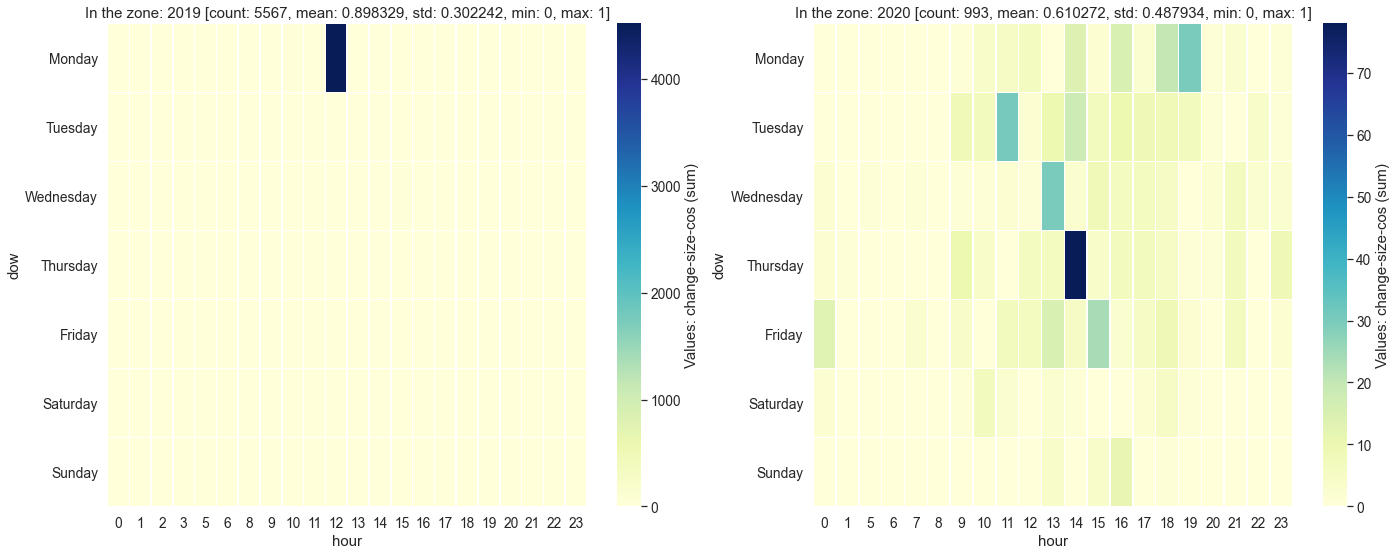

In [26]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
vis.set_year(2019)
df_2019 = vis.plot_zone_heatmap(time_range='year',fig_ax_pair = (fig,axes[0]),agg='sum')
vis.set_year(2020)
df_2020 = vis.plot_zone_heatmap(time_range='year',fig_ax_pair = (fig,axes[1]),agg='sum')

## Did anything unusual happen in 2020?
This specific function looks at how 2020 contributions compare with the average (and the previous year).

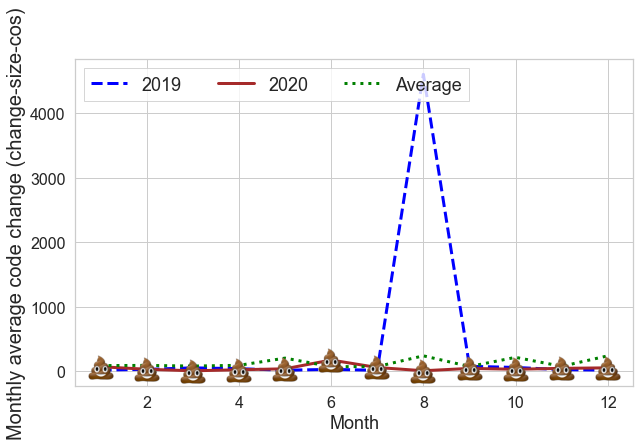

In [27]:
vis.how_was_2020('change-size-cos')

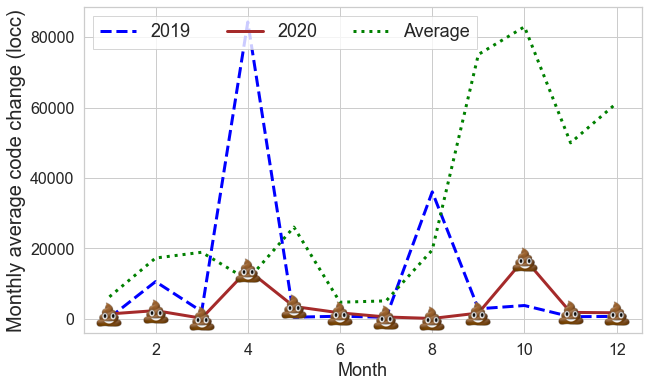

In [28]:
vis.how_was_2020('locc')